# Lesson 29: PyTorch training loop activity

In this activity, you will modify the basic PyTorch training loop from the lesson 29 demo to add:

1. **Batching** - Process the training data in mini-batches instead of all at once
2. **Validation** - Track model performance on a held-out validation set during training

## Notebook set-up

### Imports

In [1]:
# Third party imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

# Set random seeds for reproducibility
torch.manual_seed(315)
np.random.seed(315)

# Check for GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

ModuleNotFoundError: No module named 'torch'

## 1. Load preprocessed data

In [ ]:
data = pd.read_pickle('https://gperdrizet.github.io/FSA_devops/assets/data/unit4/preprocessed_housing_data.pkl')

training_df = data['training_df']
testing_df = data['testing_df']
features = data['features']
label = data['label']

print(f'Training samples: {len(training_df)}')
print(f'Testing samples: {len(testing_df)}')
print(f'Features: {features}')
print(f'Label: {label}')

Training samples: 15480
Testing samples: 5160
Features: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']
Label: MedHouseVal


## 2. Prepare PyTorch tensors and DataLoaders

### Task 1: Add batching and validation split

Currently, the code below creates tensors for training and testing. Your task is to:

1. **Add imports** for `TensorDataset` and `DataLoader` from `torch.utils.data`
2. **Split training data** into train and validation sets (e.g., 80/20 split)
3. **Create DataLoaders** for batched training

**Hints:**
- Use `torch.randperm()` to shuffle indices for the split
- Use `TensorDataset(X, y)` to combine feature and label tensors
- Use `DataLoader(dataset, batch_size=32, shuffle=True)` to create batches
- Create separate DataLoaders for training and validation

In [ ]:
# Convert dataframes to PyTorch tensors and move to device
X_train = torch.tensor(training_df[features].values, dtype=torch.float32).to(device)
y_train = torch.tensor(training_df[label].values, dtype=torch.float32).unsqueeze(1).to(device)
X_test = torch.tensor(testing_df[features].values, dtype=torch.float32).to(device)
y_test = torch.tensor(testing_df[label].values, dtype=torch.float32).unsqueeze(1).to(device)

print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: torch.Size([15480, 8])
y_train shape: torch.Size([15480, 1])
X_test shape: torch.Size([5160, 8])
y_test shape: torch.Size([5160, 1])


In [ ]:
train_dataset = TensorDataset(X_train, y_train)
test_dataset  = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
X_batch, y_batch = next(iter(train_loader))
print(X_batch.shape, y_batch.shape)

torch.Size([32, 8]) torch.Size([32, 1])


## 3. Build model

In [ ]:
model = nn.Sequential(
    nn.Linear(8, 64), # Fully connected layer (similar to tf.keras.layers.Dense)
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(32, 1)
).to(device)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-2)

print(model)

Sequential(
  (0): Linear(in_features=8, out_features=64, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.2, inplace=False)
  (3): Linear(in_features=64, out_features=32, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.2, inplace=False)
  (6): Linear(in_features=32, out_features=1, bias=True)
)


## 4. Training function

### Task 2: Update training loop for batching and validation

The current training loop processes all training data at once. Your task is to modify this function to:

1. **Accept DataLoaders** instead of raw tensors
2. **Iterate over batches** in an inner loop within each epoch
3. **Compute validation metrics** after each training epoch

**Hints:**
- Change function signature to accept `train_loader` and `val_loader` instead of `X_train`, `y_train`
- Add an inner `for X_batch, y_batch in train_loader:` loop
- Accumulate loss across batches, then average for reporting
- Use `model.eval()` and `torch.no_grad()` for validation
- Track `val_loss` and `val_r2` in the history dictionary

In [ ]:
num_epochs = 50

In [ ]:
def train_model(
    model: nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
    criterion: nn.Module,
    optimizer: optim.Optimizer,
    epochs: int = 50,
    print_every: int = 5
) -> dict[str, list[float]]:

    history = {
        'train_loss': [],
        'val_loss': [],
        'val_r2': []
    }

    for epoch in range(epochs):

        # ===== TRAIN =====
        model.train()
        running_loss = 0.0

        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()

            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)

        # ===== VALIDATE =====
        model.eval()
        val_loss = 0.0
        all_predictions = []
        all_targets = []

        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)

                val_loss += loss.item()
                all_predictions.append(outputs)
                all_targets.append(y_batch)

        avg_val_loss = val_loss / len(val_loader)

        # ===== R² =====
        all_predictions = torch.cat(all_predictions)
        all_targets = torch.cat(all_targets)

        ss_res = torch.sum((all_targets - all_predictions) ** 2)
        ss_tot = torch.sum((all_targets - torch.mean(all_targets)) ** 2)
        r2 = 1 - ss_res / ss_tot

        # ===== LOGGING =====
        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        history['val_r2'].append(r2.item())

        if (epoch + 1) % print_every == 0 or epoch == 0:
            print(
                f"Epoch {epoch+1}/{epochs} "
                f"- Train Loss: {avg_train_loss:.4f} "
                f"- Val Loss: {avg_val_loss:.4f} "
                f"- Val R²: {r2.item():.4f}"
            )

    print("\nTraining complete.")
    return history


## 5. Train model

In [ ]:
history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=test_loader,
    criterion=criterion,
    optimizer=optimizer,
    epochs=50
)

Epoch [1/50] - Train Loss: 0.2770
 Validation Loss: 0.2745
Epoch 1/50 - Train Loss: 0.2770 - Val Loss: 0.2745 - Val R²: 0.7224
Epoch [2/50] - Train Loss: 0.2684
 Validation Loss: 0.2289
Epoch [3/50] - Train Loss: 0.2690
 Validation Loss: 0.2316
Epoch [4/50] - Train Loss: 0.2662
 Validation Loss: 0.2527
Epoch [5/50] - Train Loss: 0.2694
 Validation Loss: 0.2289
Epoch 5/50 - Train Loss: 0.2694 - Val Loss: 0.2289 - Val R²: 0.7691
Epoch [6/50] - Train Loss: 0.2669
 Validation Loss: 0.2357
Epoch [7/50] - Train Loss: 0.2671
 Validation Loss: 0.2295
Epoch [8/50] - Train Loss: 0.2699
 Validation Loss: 0.2263
Epoch [9/50] - Train Loss: 0.2671
 Validation Loss: 0.2339
Epoch [10/50] - Train Loss: 0.2677
 Validation Loss: 0.2899
Epoch 10/50 - Train Loss: 0.2677 - Val Loss: 0.2899 - Val R²: 0.7077
Epoch [11/50] - Train Loss: 0.2637
 Validation Loss: 0.2342
Epoch [12/50] - Train Loss: 0.2730
 Validation Loss: 0.2539
Epoch [13/50] - Train Loss: 0.2633
 Validation Loss: 0.2170
Epoch [14/50] - Train Lo

## 6. Learning curves

**Note:** Once you add validation, update these plots to show both training and validation metrics.

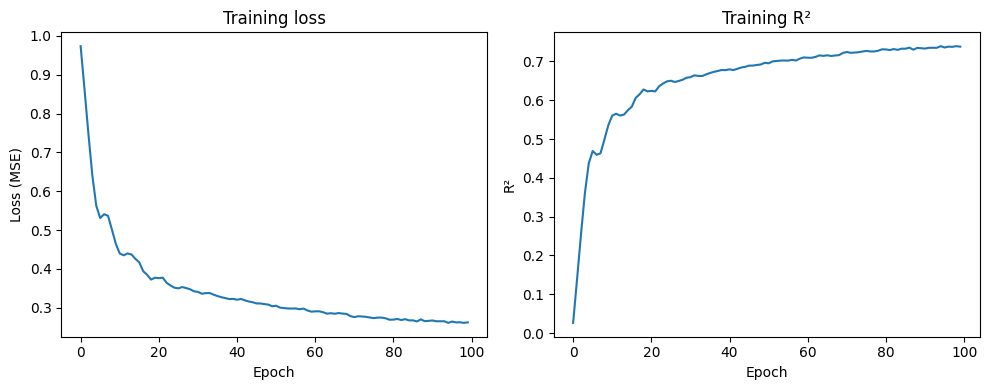

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].set_title('Training loss')
axes[0].plot(history['loss'])
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss (MSE)')

axes[1].set_title('Training R²')
axes[1].plot(history['r2'])
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('R²')

plt.tight_layout()
plt.show()

## 7. Test set evaluation

In [ ]:
# Set model to evaluation mode
model.eval()

# Make predictions (no gradient calculation needed)
with torch.no_grad():
    predictions = model(X_test).cpu().numpy().flatten()

# Calculate R²
ss_res = np.sum((testing_df[label].values - predictions) ** 2)
ss_tot = np.sum((testing_df[label].values - np.mean(testing_df[label].values)) ** 2)
rsquared = 1 - (ss_res / ss_tot)

print(f'Model R² on test set: {rsquared:.4f}')

Model R² on test set: 0.7619


## 8. Performance analysis

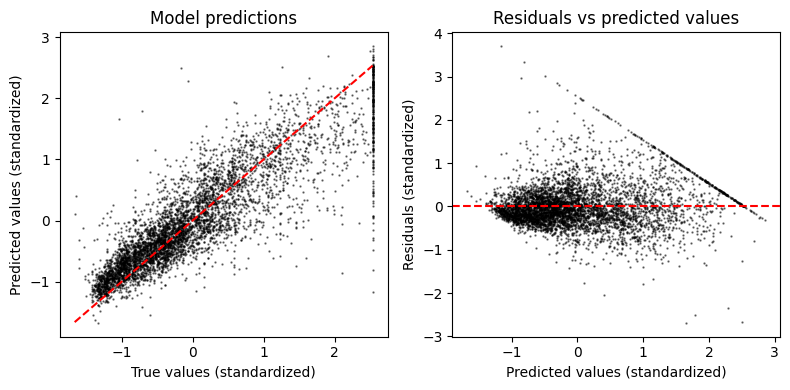

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

axes[0].set_title('Model predictions')
axes[0].scatter(
    testing_df[label], predictions,
    c='black', s=0.5, alpha=0.5
)
axes[0].plot(
    [testing_df[label].min(), testing_df[label].max()],
    [testing_df[label].min(), testing_df[label].max()],
    color='red', linestyle='--'
)
axes[0].set_xlabel('True values (standardized)')
axes[0].set_ylabel('Predicted values (standardized)')

axes[1].set_title('Residuals vs predicted values')
axes[1].scatter(
    predictions, testing_df[label] - predictions,
    c='black', s=0.5, alpha=0.5
)
axes[1].axhline(0, color='red', linestyle='--')
axes[1].set_xlabel('Predicted values (standardized)')
axes[1].set_ylabel('Residuals (standardized)')

plt.tight_layout()
plt.show()